# Play the game

In [8]:
# Let's make sure we have the right library
!pip install pygame

In [9]:
# and that we are in the right kernel
import sys
print(sys.executable)

/anaconda/envs/azureml_py38/bin/python


## 1) The game play alone - not user interaction
In thise case, we can see the game runs but since the is levels file input `game_levels_4.txt`

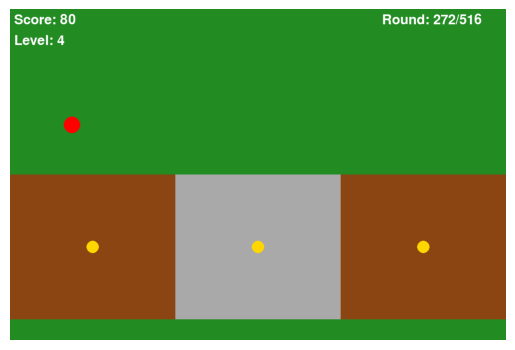

In [ ]:
import os
import pygame
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Disable sound to avoid issues in non-graphical environments
os.environ["SDL_AUDIODRIVER"] = "dummy"
pygame.mixer.init()

# Initialize Pygame
pygame.init()

# Screen dimensions (increased size)
WIDTH, HEIGHT = 1200, 800
screen = pygame.display.set_mode((WIDTH, HEIGHT))  # Create the main display surface
pygame.display.set_caption("Three Doors Challenge")

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREEN = (34, 139, 34)
RED = (255, 0, 0)
BROWN = (139, 69, 19)
GRAY = (169, 169, 169)
YELLOW = (255, 215, 0)

# Door properties
door_width = WIDTH // 3
door_height = 350  # Increased door height to match the larger screen
door_y = HEIGHT - door_height - 50

# Initial number of discrete positions
n = 1

# Ball properties
ball_radius = 20  # Increased ball size
ball_speed = 10  # Initial ball speed
ball_direction = 1  # 1 for down, -1 for up
ball_y = 50  # Initial ball position

# Font
font = pygame.font.Font(None, 48)  # Increased font size for larger screen

# Game variables
clock = pygame.time.Clock()
running = True
score = 0
current_round = 0
level = 1

# Input file containing the level details and actions
input_file = "game_levels_4.txt"  # You can change the file name here

def read_input_file(file):
    levels = {}
    with open(file, "r") as f:
        lines = f.readlines()
    
    level = None
    rounds_per_level = 0
    rounds = []
    
    for line in lines:
        line = line.strip()
        if not line or line.startswith("#"):  # Skip empty lines and comments
            continue
        if line.startswith("level:"):
            if level is not None:
                levels[level] = (rounds_per_level, rounds)
            level = int(line.split(":")[1].strip())
            rounds = []
        elif line.startswith("rounds:"):
            rounds_per_level = int(line.split(":")[1].strip())
        else:
            parts = line.split()
            if len(parts) >= 2:  # Ensure there are at least two elements
                ball_position_index = int(parts[0]) - 1
                action = parts[1].strip()
                rounds.append((ball_position_index, action))
            else:
                print(f"Warning: Skipping improperly formatted line: '{line}'")
    
    if level is not None:
        levels[level] = (rounds_per_level, rounds)
    
    return levels

# Load the input data (dictionary where each key is a level number, and each value is a tuple of rounds_per_level and list of (ball_position_index, action))
levels_data = read_input_file(input_file)

def update_positions(n):
    """Update the ball positions based on the current value of n."""
    return [(i + 0.5) * (door_width / n) for i in range(n)] + \
           [WIDTH // 2] + \
           [(2 * door_width) + (i + 0.5) * (door_width / n) for i in range(n)]

ball_x_positions = update_positions(n)

# Mapping of discrete positions to doors
def update_position_to_door(n):
    return {
        (0, n - 1): "left",             # Left door for first n positions
        n: "middle",                    # Middle door for the single middle position
        (n + 1, 2 * n): "right",        # Right door for the last n positions
    }

position_to_door = update_position_to_door(n)
door_open = "middle"  # Default to middle door open
door_animation = False
door_animation_frames = 8  # Number of frames for the door animation (faster animation)

def get_door_for_position(pos_index):
    for key, door in position_to_door.items():
        if isinstance(key, tuple):
            start, end = key
            if start <= pos_index <= end:
                return door
        elif key == pos_index:
            return door
    return None

def draw_doors(open_door, animate=False, frame=0):
    door_gap = door_width // 2  # Initial door gap
    handle_position = door_width // 2  # Handle in the middle

    if animate:
        # Animate the door opening
        door_gap = door_gap * (frame / door_animation_frames)

    # Draw the left door
    left_door_rect = pygame.Rect(0, door_y, door_width, door_height)
    pygame.draw.rect(screen, BROWN, left_door_rect)
    if open_door == "left":
        pygame.draw.rect(screen, GRAY, (door_width // 2 - door_gap, door_y, door_gap, door_height))  # Left half
        pygame.draw.rect(screen, GRAY, (door_width // 2, door_y, door_gap, door_height))  # Right half
    pygame.draw.circle(screen, YELLOW, (door_width // 2, door_y + door_height // 2), 15)

    # Draw the middle door
    middle_door_rect = pygame.Rect(door_width, door_y, door_width, door_height)
    pygame.draw.rect(screen, BROWN, middle_door_rect)
    if open_door == "middle":
        pygame.draw.rect(screen, GRAY, (WIDTH // 2 - door_gap, door_y, door_gap, door_height))  # Left half
        pygame.draw.rect(screen, GRAY, (WIDTH // 2, door_y, door_gap, door_height))  # Right half
    pygame.draw.circle(screen, YELLOW, (WIDTH // 2, door_y + door_height // 2), 15)

    # Draw the right door
    right_door_rect = pygame.Rect(2 * door_width, door_y, door_width, door_height)
    pygame.draw.rect(screen, BROWN, right_door_rect)
    if open_door == "right":
        pygame.draw.rect(screen, GRAY, (2 * door_width + door_width // 2 - door_gap, door_y, door_gap, door_height))  # Left half
        pygame.draw.rect(screen, GRAY, (2 * door_width + door_width // 2, door_y, door_gap, door_height))  # Right half
    pygame.draw.circle(screen, YELLOW, (2 * door_width + door_width // 2, door_y + door_height // 2), 15)

def draw_ball(ball_x, ball_y):
    pygame.draw.circle(screen, RED, (ball_x, ball_y), ball_radius)

def display_transition_message(screen, level, n):
    """Display the transition message on the screen."""
    screen.fill(GREEN)
    message = f"Game Solved! Moving to next level n = {n}"
    text = font.render(message, True, BLACK)
    text_rect = text.get_rect(center=(WIDTH // 2, HEIGHT // 2))
    screen.blit(text, text_rect)
    pygame.display.flip()
    pygame.time.delay(2000)  # Pause for 2 seconds before continuing

def increase_speed():
    global ball_speed
    ball_speed += 2  # Increase ball speed

def decrease_speed():
    global ball_speed
    ball_speed = max(2, ball_speed - 2)  # Decrease ball speed, but not below 2

def save_screenshot_as_matplotlib_image():
    """Capture the Pygame screen and convert it to a Matplotlib image for display."""
    img_str = pygame.image.tostring(screen, "RGB")
    img = pygame.image.fromstring(img_str, (WIDTH, HEIGHT), "RGB")
    plt.imshow(pygame.surfarray.array3d(img).swapaxes(0, 1))
    plt.axis('off')
    clear_output(wait=True)
    plt.show()

# Main game loop
for level, (rounds_per_level, round_data) in sorted(levels_data.items()):
    n = level  # Increment n with each level
    ball_x_positions = update_positions(n)
    position_to_door = update_position_to_door(n)
    current_round = 0
    
    for ball_position_index, action in round_data:
        ball_y = 50  # Reset ball position for the new round
        
        while ball_y < door_y - ball_radius:
            # Handle events
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    exit()

            # Clear the screen
            screen.fill(GREEN)  # Clear the screen before drawing each frame
            
            # Move the ball
            ball_y += ball_speed * ball_direction

            # Map action to door_open
            if action == "left":
                door_open = "left"
            elif action == "right":
                door_open = "right"
            elif action == "middle":
                door_open = "middle"

            # Draw doors
            draw_doors(door_open)

            # Draw ball
            draw_ball(ball_x_positions[ball_position_index], ball_y)

            # Draw the Score, Level, and Rounds labels
            score_text = font.render(f"Score: {score}", True, WHITE)
            level_text = font.render(f"Level: {level}", True, WHITE)
            rounds_text = font.render(f"Round: {current_round + 1}/{rounds_per_level}", True, WHITE)
            screen.blit(score_text, (10, 10))
            screen.blit(level_text, (10, 60))
            screen.blit(rounds_text, (WIDTH - 300, 10))

            # Update the display using Matplotlib and tick the clock
            save_screenshot_as_matplotlib_image()
            clock.tick(30)

        # Check if ball enters the open door
        expected_door = get_door_for_position(ball_position_index)
        if door_open == expected_door:
            print("You scored a point!")
            score += 1
            door_animation = True
            for frame in range(door_animation_frames):
                screen.fill(GREEN)
                draw_doors(door_open, animate=True, frame=frame)
                draw_ball(ball_x_positions[ball_position_index], ball_y)
                save_screenshot_as_matplotlib_image()
                clock.tick(60)  # Faster animation with 60 frames per second
            door_animation = False
        else:
            print("Missed!")
        # Increment round count
        current_round += 1

    # Display transition message before moving to the next level
    display_transition_message(screen, level + 1, level + 1)

pygame.quit()

print(f"Final Score: {score}")


### Let's now clean the images:

In [ ]:
import os
import glob

# Find all PNG files that match the pattern "round_*.png"
png_files = glob.glob("round_*.png")

# Loop through and remove each file
for file in png_files:
    os.remove(file)
    print(f"Deleted {file}")

print("All round screenshots have been removed.")


## - end -